In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

In [2]:
'''
This section will take the csv from airtable and make it into a geojson to use in the next chunk
'''
# Read the CSV file
df = pd.read_csv('Locations-HuronWatershed.csv')

# Split the column containing "lat lon" into separate latitude and longitude columns
df[['lat', 'lon']] = df['Latitude, Longitude'].str.split(',', expand=True)
del df['Latitude, Longitude']

# Create a GeoDataFrame
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
crs = {'init': 'epsg:4326'}  # assuming WGS84 coordinates
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs=crs)

# Convert to GeoJSON
output_geojson = 'Huron_sensors.geojson'
gdf.to_file(output_geojson, driver='GeoJSON')


/Users/shinapatel/anaconda3/envs/geo_env/lib/python3.12/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Text(81.14811467980415, 0.5, 'Latitude')

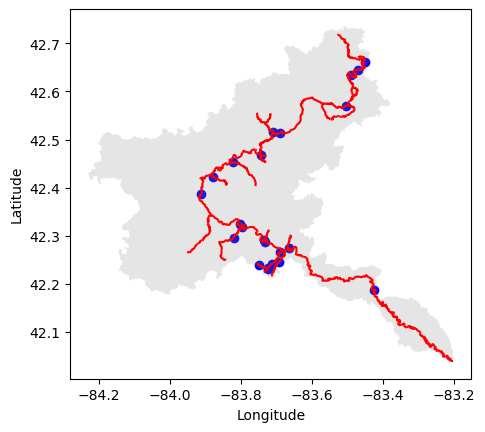

In [3]:
# Load GeoJSON files into GeoDataFrames
sensor_file = 'Huron_sensors.geojson'
river_file = 'Huron_RiverSystem.geojson'
watershed_file = "Huron_Watershed.geojson"

sensor = gpd.read_file(sensor_file)
river = gpd.read_file(river_file)
watershed = gpd.read_file(watershed_file)

# Plot GeoDataFrames on the same plot
ax = sensor.plot(color='blue', label='DWL @ UM sensors')
river.plot(ax=ax, color='red', label='Rivers')
watershed.plot(ax=ax, color='gray', label='Watershed', alpha = 0.2)

# Add legends and labels
# ax.legend()
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

